In [1]:
# generate maskW, maskS, maskK, and maskT for cost_gencost_boxmean.F, variable 'm_horflux_vol'
# we are setting up to do two experiments, near surface and near undercurrent zonal transport sensitivity 
# no meridional transport included
# we want to look at the sensitivity of a 1 day average zonal transport 

from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 96,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45585,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 96
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:37185,Total threads: 8
Dashboard: http://127.0.0.1:39021/status,Memory: 83.91 GiB
Nanny: tcp://127.0.0.1:39637,


In [2]:
## Read in ITER 0 Diagnostics 
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import xarray as xr
from xmitgcm import open_mdsdataset
import numpy as np
import warnings
# warnings.filterwarnings("ignore")

data_dir = '/data/SO3/edavenport/tpose6/sep2012/run_iter0/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = ['diag_state']
tpose_ds = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200)
depths = tpose_ds.Z.values
lons = tpose_ds.XC.values
lats = tpose_ds.YC.values


In [3]:
# W and S are 2D, K and T are 1D 

maskW = np.zeros_like(tpose_ds.THETA[0,0,:,:].values,dtype=np.int32) # set to 1 where we want to include zonal transport
maskS = np.zeros_like(tpose_ds.THETA[0,0,:,:].values,dtype=np.int32) # Set to 1 where we want to include meridional transport
maskK = np.zeros_like(tpose_ds.THETA[0,:,0,0].values,dtype=np.int32) # set to 1 for depths that we want to be included
maskT = np.zeros_like(tpose_ds.THETA[:,0,0,0].values,dtype=np.int32) # set to 1 for times that we want to be included

In [4]:
print(maskW.shape,maskS.shape,maskK.shape,maskT.shape)

(336, 1128) (336, 1128) (66,) (122,)


In [5]:
# set T mask
maskT[-1] = 1 

# set K masks
maskK_surface = maskK.copy()
maskK_EUC = maskK.copy()

depthui = np.argmin(np.abs(depths - -60.0)) 
maskK_surface[:depthui] = 1
depthli = depthui
depthui = np.argmin(np.abs(depths - -160.0)) 
maskK_EUC[depthli:depthui] = 1

# set W mask (line from 1S to 1N at 140W)
lonidx = np.argmin(np.abs(lons - 220.0))
latui = np.argmin(np.abs(lats - 1.0))
latli = np.argmin(np.abs(lats - -1.0))
maskW[latli:latui,lonidx] = 1

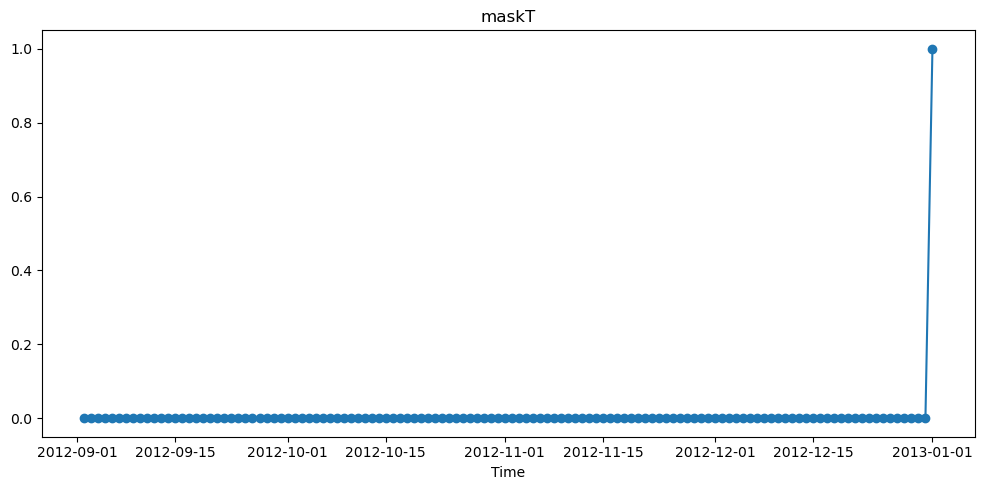

In [6]:

fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(tpose_ds.time.values,maskT,marker='o')
ax.set_xlabel('Time')
ax.set_title('maskT')
plt.tight_layout()


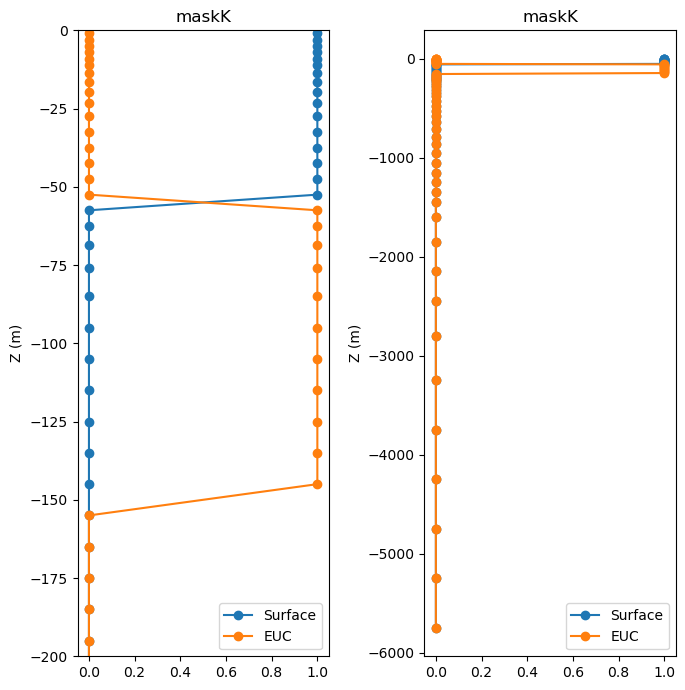

In [7]:
fig,ax = plt.subplots(1,2,figsize=(7,7))
ax[0].plot(maskK_surface,tpose_ds.Z.values,marker='o',label='Surface')
ax[0].plot(maskK_EUC,tpose_ds.Z.values,marker='o',label='EUC')
ax[0].set_ylim(-200,0)
ax[0].legend()
ax[0].set_title('maskK')
ax[0].set_ylabel('Z (m)')

ax[1].plot(maskK_surface,tpose_ds.Z.values,marker='o',label='Surface')
ax[1].plot(maskK_EUC,tpose_ds.Z.values,marker='o',label='EUC')
ax[1].legend()
ax[1].set_title('maskK')
ax[1].set_ylabel('Z (m)')
plt.tight_layout()


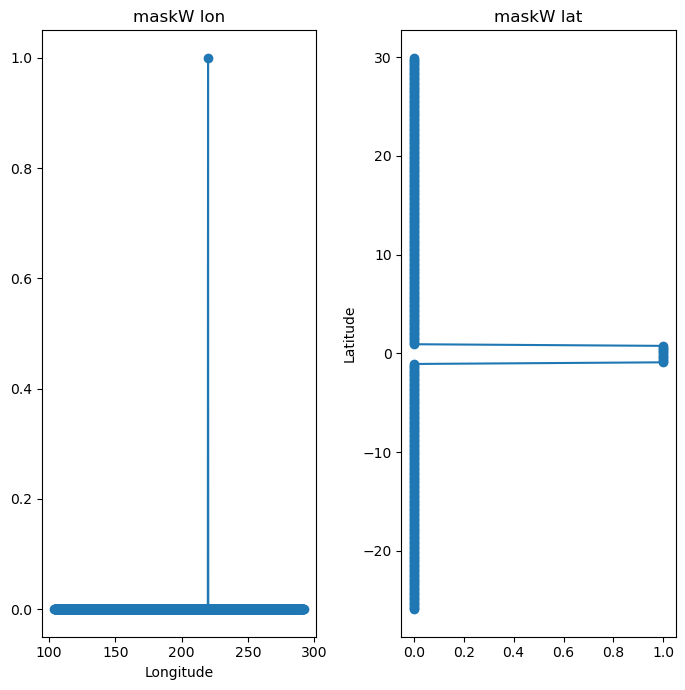

In [8]:
fig,ax = plt.subplots(1,2,figsize=(7,7))
ax[0].plot(tpose_ds.XC.values,maskW[latli+5,:],marker='o')
ax[0].set_title('maskW lon')
ax[0].set_xlabel('Longitude')

ax[1].plot(maskW[:,lonidx],tpose_ds.YC.values,marker='o')
ax[1].set_title('maskW lat')
ax[1].set_ylabel('Latitude')
plt.tight_layout()

In [11]:
maskS.tofile('/home/edavenport/analysis/TPOSE6_Sensitivity/model_setup/surface_transect/maskS.bin')
maskT.tofile('/home/edavenport/analysis/TPOSE6_Sensitivity/model_setup/surface_transect/maskT.bin')
maskW.tofile('/home/edavenport/analysis/TPOSE6_Sensitivity/model_setup/surface_transect/maskW.bin')
maskK_surface.tofile('/home/edavenport/analysis/TPOSE6_Sensitivity/model_setup/surface_transect/maskK.bin')

maskS.tofile('/home/edavenport/analysis/TPOSE6_Sensitivity/model_setup/EUC_transect/maskS.bin')
maskT.tofile('/home/edavenport/analysis/TPOSE6_Sensitivity/model_setup/EUC_transect/maskT.bin')
maskW.tofile('/home/edavenport/analysis/TPOSE6_Sensitivity/model_setup/EUC_transect/maskW.bin')
maskK_EUC.tofile('/home/edavenport/analysis/TPOSE6_Sensitivity/model_setup/EUC_transect/maskK.bin')